In [1]:
# Vegetable Classification with the 'Vegetable' dataset expanded with extra images of broccoli, cauliflower, carrot and tomato from different datasets
# Transfer Learning with different base models and check the differences

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import os, warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [7]:
dataset = '../../../dataset_extra_data/'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

In [3]:
IMAGE_SIZE = [224, 224, 3]

inception = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(5, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

2022-06-28 16:23:36.424468: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


87924736/87910968 [==============================] - 8s 0us/step


In [8]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 32, 
    class_mode = 'categorical')

Found 5000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [15]:
class_map = training_set.class_indices
class_map

{'Bean': 0, 'Broccoli': 1, 'Carrot': 2, 'Cauliflower': 3, 'Tomato': 4}

In [18]:
class_names = list(class_map.keys())
class_names

['Bean', 'Broccoli', 'Carrot', 'Cauliflower', 'Tomato']

In [12]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
  6/157 [>.............................] - ETA: 3:07 - loss: 0.0677 - accuracy: 0.9844

KeyboardInterrupt: 

In [22]:
model.save('model_inceptionV3_epoch5.h5')

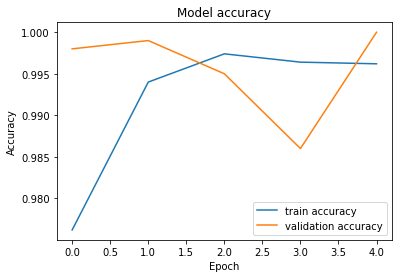

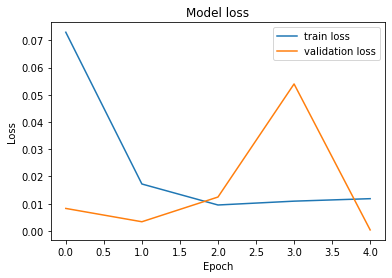

In [20]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

In [21]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]: 
    layer_names.append(layer.name)
    
print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

Total layers in the model :  315 

First layer :  input_2
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d_1', 'dense_2', 'dropout_1']
Final Layer :  dense_3


In [13]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [25]:
validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 1000 images belonging to 5 classes.
Test Accuracy: 1.000


In [25]:
def predict_image(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    prediction = class_names[np.argmax(score)]

    return prediction

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def labels_confusion_matrix(folder_path):
    real=[]
    predicted=[]


    for i in os.listdir(folder_path):
        
        true = i
        
        for j in os.listdir(os.path.join(folder_path,i)):

            prediction = predict_image(os.path.join(folder_path,i,j))

            predicted.append(prediction)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    cm_plot_labels = [i for i in range(5)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2)
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap="turbo")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

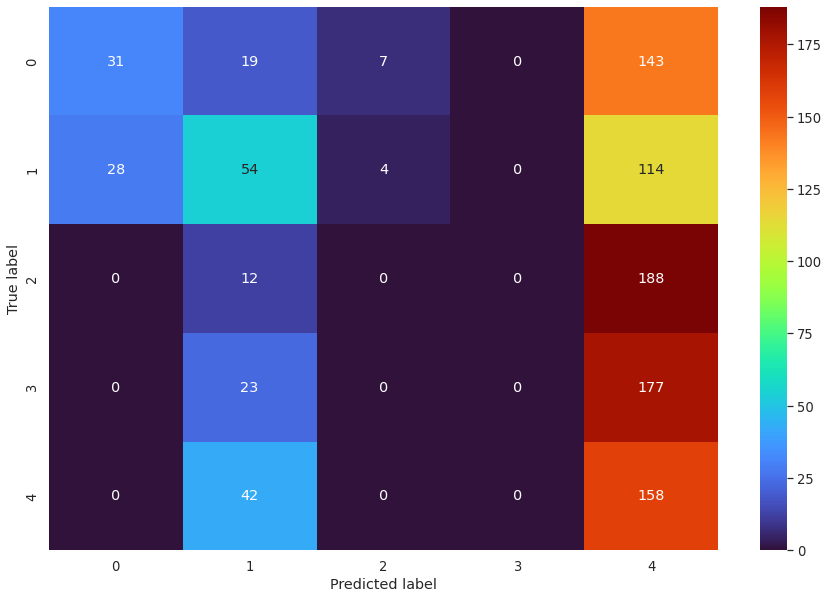

In [26]:
test_path = os.path.join('..', '..', '..', 'dataset_extra_data', 'validation')

y_true,y_pred=labels_confusion_matrix(test_path)
print_confusion_matrix(y_true,y_pred)